In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from pathlib import Path

import shamans.utils.eval_utils as eval

In [ ]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False, encoding='utf-8-sig')
    return combined_csv

In [ ]:
# load data
exp_id = 3
path_to_results = Path('results/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)

In [19]:
# compute accuracy and recall for each doas estimated by each method within a threshold of 10 degrees

def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

exp_df['ang_error'] = calc_ae(
    np.rad2deg(exp_df['doas_est_az']), 
    np.rad2deg(exp_df['doas_ref_az'])
)

ang_error_threshold_choices = [5, 10, 15, 20]

# compute accuracy and recall based on the frame id as in DCASE Task 3
unique_frame_ids = exp_df['frame_id'].unique()
unique_method_ids = exp_df['method_id'].unique()

df_thresholds = pd.DataFrame()

for frame_id in tqdm(unique_frame_ids, desc='frame'):
    df_frame = exp_df[exp_df['frame_id'] == frame_id]
    
    for method_id in unique_method_ids:
        df_method = df_frame[df_frame['method_id'] == method_id]    
                
        assert len(df_method) == np.unique(df_method['doas_est_az']).shape[0] == np.unique(df_method['n_sources'])
            
        # accuracy and mean error
        for thr in ang_error_threshold_choices:
            
            accuracy = np.sum(df_method['ang_error'] <= thr) / len(df_method)
            error = np.mean(df_method[df_method['ang_error'] <= thr]['ang_error'])

            df_ = pd.DataFrame({
                "frame_id": frame_id,
                "method_id": method_id,
                "accuracy": accuracy,
                "mean_error": error,
                "threshold": thr
            }, index=[0])
            df_thresholds = pd.concat([df_thresholds, df_], ignore_index=True)

frame: 100%|██████████| 120/120 [00:37<00:00,  3.20it/s]


In [ ]:
df_merge = exp_df.merge(df_thresholds, on=['frame_id', 'method_id'])

In [23]:
print('accuracy for 5 degree, the higher the better')
df_pivot = df_merge[
        (df_merge['seed'] == 13)
        & (df_merge['threshold'] == 10)
        & (df_merge['duration'] == 0.5)
].pivot_table(
        values='accuracy', 
        columns=['n_sources'],
        index=['sv_method', 'nObs', 'seed', 'loc_method'], 
        aggfunc='mean'
)
df_pivot.style.background_gradient(cmap='viridis', axis=1)

accuracy for 5 degree, the higher the better


KeyError: 'loc_method_simple'

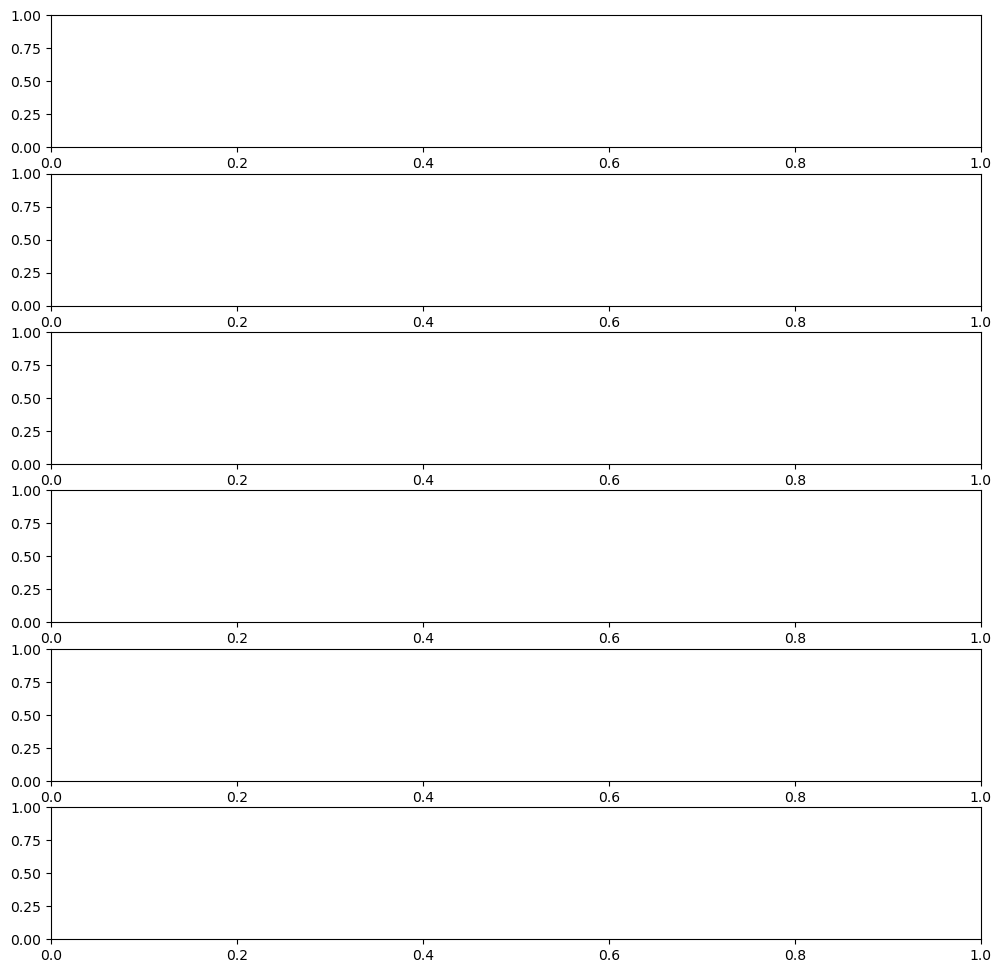

In [24]:
n_max_sources = np.max(df_merge['n_sources'])
loc_methods = np.unique(df_merge['loc_method'])
sv_methods = np.unique(df_merge['sv_method'])

fig, axarr = plt.subplots(n_max_sources, 1, figsize=(12, 12))

# df_merge['loc_method_simple'] = df_merge['loc_method'].apply(lambda x: x.split('-')[0])

print(df_merge['loc_method_simple'].unique())

for i, n_sources in enumerate(range(n_max_sources)):
    # for j, loc_method in enumerate(loc_methods):

        df_ = df_merge[
                (df_merge['seed'] == 13)
            & (df_merge['threshold'] == 10)
            & (df_merge['n_sources'] == n_sources+1)
            & (df_merge['record_id'] == 's0')
            & (df_merge['duration'] == 0.5)
            # & (df_merge['loc_method_simple'].isin(['srp_phat', 'music', 'alpha']))
        ]
        
        df_ = df_.assign(method_extended=df_['sv_method'] + '_' + df_['nObs'].astype(str))
    
        sns.barplot(
            data=df_,
            x='method_extended',
            y='accuracy',
            hue='loc_method',
            # y='mean_error',
            ax=axarr[i],
        )
        # place legend above plot
        if i == 0:
            axarr[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=4)
        else:
            axarr[i].get_legend().remove()
        axarr[i].set_title(f'{n_sources+1} sources')
plt.tight_layout()